# Using VisCube with XRADIO

NRAO is gradually phasing out the current version of CASA for a new, fully modular, Python-native version. As part of the beginning of this transition, a new measurement set version (MS v4.0) and a new way to handle measurement set I/O (XRADIO) has been released. XRADIO's I/O speed is generally faster than regular CASA for large measurement sets if run on a device with multi-core processing. For more information on XRADIO, please see here: https://xradio.readthedocs.io/en/latest/

### Step -1: Download data

In this example, we are using continuum data of lensed galaxy SPT0418, downloaded from the ALMA archive. We will be demonstrating both UVW and UV gridding in VisCube.

### Step 0: Make sure to install XRADIO (see the link above).

In [2]:
from xradio.measurement_set import estimate_conversion_memory_and_cores
import toolviper
from xradio.measurement_set import convert_msv2_to_processing_set
from xradio.measurement_set import open_processing_set
from pprint import pprint
from tqdm import tqdm
import matplotlib.pyplot as plt
from astropy.constants import c
import numpy as np

### Step 1: For simplicity, let's assume you're starting with a regular MS (v2.0) which contains continuum (single channel) data. We need to convert it to a MS v4.0 as follows.

##### N.B., the first cell below will help you gauge whether your machine has enough compute to handle the conversion to MS v4.0, which can be quite intensive.

Once the conversion is complete, it will save the new measurement set as a .zarr file in the path location. 

In [ ]:
# Replace the line below with the path to your measurement set.
path = "/home/darthbarth/Data/spt0418/ALMA_low_res/low_res_obs"

mem_estimate, max_reasonable_cores, suggested_cores = estimate_conversion_memory_and_cores(path)
mem_estimate, max_reasonable_cores, suggested_cores

In [ ]:
# Under the hood, XRADIO uses DASK for parallel processing.
do_parallel = True
if do_parallel:
    from toolviper import dask
    viper_client = toolviper.dask.local_client(cores=suggested_cores)

In [ ]:
# Convert to MS v4.0
convert_out = "/home/darthbarth/Data/spt0418/ALMA_low_res/low_res_obs.zarr"
convert_msv2_to_processing_set(
    in_file=path,
    out_file=convert_out,
    overwrite=True,
    parallel=do_parallel,
)

### Step 2: Load the measurement set into memory using XRADIO.

The `summary()` feature allows you to see a high-level overview of the measurement set without loading all of the column data itself into memory.

In [3]:
# This cell just defines the paths for things
convert_out = "/home/darthbarth/Data/spt0418/ALMA_low_res/low_res_obs.zarr"

# continuum “one channel” handling:
# We will still use all frequency samples, but treat them as one continuum dataset
# after converting u,v,w to wavelengths.
n_avg = 8  # keep your chunk-averaging, optional

# where to save extracted continuum arrays
out_dir = "/home/darthbarth/Big_red/transformer_data"
u_path = f"{out_dir}/u_continuum.npy"
v_path = f"{out_dir}/v_continuum.npy"
w_path = f"{out_dir}/w_continuum.npy"
data_path = f"{out_dir}/data_continuum.npy"
weights_path = f"{out_dir}/weights_continuum.npy"

# where to save gridded cube
uvw_grid_npz = f"{out_dir}/uvw_gridded_continuum.npz"

In [4]:
# -----------------------------
# Load processing set
# -----------------------------
ps = open_processing_set(convert_out, intents=["OBSERVE_TARGET#ON_SOURCE"])
ps.summary()

,name,intents,shape,polarization,scan_number,spw_name,field_name,source_name,line_name,field_coords,start_frequency,end_frequency
6,low_res_obs_0,[OBSERVE_TARGET#ON_SOURCE],"(320, 946, 128, 2)","[XX, YY]","[10, 13, 16, 21, 24, 27]",X190789818#ALMA_RB_07#BB_3#SW-01#FULL_RES_0,[SPT-0418_4],[SPT-0418_4],[BaseBand3_cont(ID=0)],"[icrs, 4h18m39.27s, -47d51m50.10s]",3.498007e+11,3.517851e+11
5,low_res_obs_1,[OBSERVE_TARGET#ON_SOURCE],"(320, 946, 128, 2)","[XX, YY]","[10, 13, 16, 21, 24, 27]",X190789818#ALMA_RB_07#BB_4#SW-01#FULL_RES_1,[SPT-0418_4],[SPT-0418_4],[BaseBand4_cont(ID=0)],"[icrs, 4h18m39.27s, -47d51m50.10s]",3.516762e+11,3.536606e+11
2,low_res_obs_2,[OBSERVE_TARGET#ON_SOURCE],"(320, 946, 480, 2)","[XX, YY]","[10, 13, 16, 21, 24, 27]",X190789818#ALMA_RB_07#BB_1#SW-01#FULL_RES_2,[SPT-0418_4],[SPT-0418_4],[CII_2P3_2_2P1_2(ID=7025460)],"[icrs, 4h18m39.27s, -47d51m50.10s]",3.619230e+11,3.637941e+11
4,low_res_obs_3,[OBSERVE_TARGET#ON_SOURCE],"(320, 946, 480, 2)","[XX, YY]","[10, 13, 16, 21, 24, 27]",X190789818#ALMA_RB_07#BB_2#SW-01#FULL_RES_3,[SPT-0418_4],[SPT-0418_4],[CII_2P3_2_2P1_2_RIGHT(ID=0)],"[icrs, 4h18m39.27s, -47d51m50.10s]",3.636734e+11,3.655445e+11
3,low_res_obs_4,[OBSERVE_TARGET#ON_SOURCE],"(320, 861, 128, 2)","[XX, YY]","[38, 41, 44, 49, 52, 55]",X190789818#ALMA_RB_07#BB_3#SW-01#FULL_RES_4,[SPT-0418_4],[SPT-0418_4],[BaseBand3_cont(ID=0)],"[icrs, 4h18m39.27s, -47d51m50.10s]",3.498004e+11,3.517847e+11
0,low_res_obs_5,[OBSERVE_TARGET#ON_SOURCE],"(320, 861, 128, 2)","[XX, YY]","[38, 41, 44, 49, 52, 55]",X190789818#ALMA_RB_07#BB_4#SW-01#FULL_RES_5,[SPT-0418_4],[SPT-0418_4],[BaseBand4_cont(ID=0)],"[icrs, 4h18m39.27s, -47d51m50.10s]",3.516758e+11,3.536602e+11
1,low_res_obs_6,[OBSERVE_TARGET#ON_SOURCE],"(320, 861, 480, 2)","[XX, YY]","[38, 41, 44, 49, 52, 55]",X190789818#ALMA_RB_07#BB_1#SW-01#FULL_RES_6,[SPT-0418_4],[SPT-0418_4],[CII_2P3_2_2P1_2(ID=7025460)],"[icrs, 4h18m39.27s, -47d51m50.10s]",3.619226e+11,3.637937e+11
7,low_res_obs_7,[OBSERVE_TARGET#ON_SOURCE],"(320, 861, 480, 2)","[XX, YY]","[38, 41, 44, 49, 52, 55]",X190789818#ALMA_RB_07#BB_2#SW-01#FULL_RES_7,[SPT-0418_4],[SPT-0418_4],[CII_2P3_2_2P1_2_RIGHT(ID=0)],"[icrs, 4h18m39.27s, -47d51m50.10s]",3.636730e+11,3.655441e+11


### Step 3: Choose your spectral window(s) (spw), and then for each spw, load into memory the relevant columns (frequency, time, polarization, visibilities, weights) from the measurement set.

We do quite a bit of post-processing in this step as well (these steps may require adjustment for your data). In the order they are performed, the post-processing steps are:
1. Remove autocorrelations
2. Remove flagged data
3. Average over polarizations (to get an "unpolarized" output)
4. Frequency averaging. In this case, since we are working with a continuum dataset, we average the frequencies in bins on 8 bins, and then we flatten everything. If you are working with a spectral cube, you will need to change the following code block to correctly reshape the arrays to the number of frequency bins you would like to use (in this example, it would be 13):
   ```
   # Convert u,v,w from meters -> wavelengths via u_lambda = u_m * nu / c
    u_lambda = (u_avg_freq_m * freq_avg / c.value).flatten()
    v_lambda = (v_avg_freq_m * freq_avg / c.value).flatten()
    w_lambda = (w_avg_freq_m * freq_avg / c.value).flatten()

    vis_flat = vis_avg_freq.flatten()
    weights_flat = weights_avg_freq.flatten()
   ```
5. Convert u,v,w from meters to lambda

In [5]:
spws = [0]  # you set continuum on spw 0

In [7]:
# -----------------------------
# Extract u,v,w in wavelengths + continuum vis/weights
# -----------------------------
u_list, v_list, w_list, data_list, weights_list = [], [], [], [], []

for i in tqdm(range(len(spws))):
    xds0 = ps[f"low_res_obs_{spws[i]}"]
    freq = xds0.frequency
    time = len(xds0.time)
    pol = len(xds0.polarization)

    # Remove autocorr (x-corr)
    ant1 = (
        xds0.baseline_antenna1_name
        .expand_dims({"time": time}, axis=0)
        .expand_dims({"frequency": len(freq)}, axis=2)
        .expand_dims({"polarization": pol}, axis=-1)
    )
    ant2 = (
        xds0.baseline_antenna2_name
        .expand_dims({"time": time}, axis=0)
        .expand_dims({"frequency": len(freq)}, axis=2)
        .expand_dims({"polarization": pol}, axis=-1)
    )

    visibilities = xds0.VISIBILITY.where((ant1 != ant2).compute(), drop=True)
    weights = xds0.WEIGHT.where((ant1 != ant2).compute(), drop=True)

    # UVW in meters from the MS; expand to match dims and drop autocorr
    u_m = xds0.UVW[:, :, 0].expand_dims({"frequency": len(freq)}, axis=2).expand_dims({"polarization": pol}, axis=-1).where((ant1 != ant2).compute(), drop=True)
    v_m = xds0.UVW[:, :, 1].expand_dims({"frequency": len(freq)}, axis=2).expand_dims({"polarization": pol}, axis=-1).where((ant1 != ant2).compute(), drop=True)
    w_m = xds0.UVW[:, :, 2].expand_dims({"frequency": len(freq)}, axis=2).expand_dims({"polarization": pol}, axis=-1).where((ant1 != ant2).compute(), drop=True)

    # Remove flagged data
    flags = xds0.FLAG.where((ant1 != ant2).compute(), drop=True)
    flagged_vis = visibilities.where((flags == 0).compute(), drop=True).compute()
    flagged_weights = weights.where((flags == 0).compute(), drop=True).compute()
    flagged_u_m = u_m.where((flags == 0).compute(), drop=True).compute()
    flagged_v_m = v_m.where((flags == 0).compute(), drop=True).compute()
    flagged_w_m = w_m.where((flags == 0).compute(), drop=True).compute()

    # Average over polarizations (assumes pol is last axis)
    vis_avg = flagged_vis.mean(axis=-1)
    weights_avg = flagged_weights.mean(axis=-1)
    u_avg_m = flagged_u_m.mean(axis=-1)
    v_avg_m = flagged_v_m.mean(axis=-1)
    w_avg_m = flagged_w_m.mean(axis=-1)

    # Frequency averaging in chunks
    n_freq = vis_avg.shape[-1]
    print(n_freq)
    remainder = n_freq % n_avg
    if remainder != 0:
        n_freq_new = n_freq - remainder
        freq = freq.isel(frequency=slice(0, n_freq_new))
        vis_avg = vis_avg.isel(frequency=slice(0, n_freq_new))
        weights_avg = weights_avg.isel(frequency=slice(0, n_freq_new))
        u_avg_m = u_avg_m.isel(frequency=slice(0, n_freq_new))
        v_avg_m = v_avg_m.isel(frequency=slice(0, n_freq_new))
        w_avg_m = w_avg_m.isel(frequency=slice(0, n_freq_new))

    new_freq_dim = n_freq // n_avg
    vis_avg_freq = vis_avg.values.reshape(vis_avg.shape[0], vis_avg.shape[1], new_freq_dim, n_avg).mean(axis=3)
    print(vis_avg_freq.shape)
    weights_avg_freq = weights_avg.values.reshape(weights_avg.shape[0], weights_avg.shape[1], new_freq_dim, n_avg).mean(axis=3)

    u_avg_freq_m = u_avg_m.values.reshape(u_avg_m.shape[0], u_avg_m.shape[1], new_freq_dim, n_avg).mean(axis=3)
    v_avg_freq_m = v_avg_m.values.reshape(v_avg_m.shape[0], v_avg_m.shape[1], new_freq_dim, n_avg).mean(axis=3)
    w_avg_freq_m = w_avg_m.values.reshape(w_avg_m.shape[0], w_avg_m.shape[1], new_freq_dim, n_avg).mean(axis=3)

    freq_avg = freq.values.reshape(new_freq_dim, n_avg).mean(axis=1)  # Hz

    # Convert u,v,w from meters -> wavelengths via u_lambda = u_m * nu / c
    u_lambda = (u_avg_freq_m * freq_avg / c.value).flatten()
    v_lambda = (v_avg_freq_m * freq_avg / c.value).flatten()
    w_lambda = (w_avg_freq_m * freq_avg / c.value).flatten()

    vis_flat = vis_avg_freq.flatten()
    weights_flat = weights_avg_freq.flatten()

    data_list.append(vis_flat)
    weights_list.append(weights_flat)
    u_list.append(u_lambda)
    v_list.append(v_lambda)
    w_list.append(w_lambda)

  0%|                                                     | 0/1 [00:00<?, ?it/s]

111
(320, 903, 13)


100%|█████████████████████████████████████████████| 1/1 [00:26<00:00, 26.83s/it]


### Step 4: Save extracted data into numpy arrays

In [10]:
u_flat = np.concatenate(u_list)
v_flat = np.concatenate(v_list)
w_flat = np.concatenate(w_list)
data_flat = np.concatenate(data_list)
weights_flat = np.concatenate(weights_list)

np.save(u_path, u_flat)
np.save(v_path, v_flat)
np.save(w_path, w_flat)
np.save(data_path, data_flat)
np.save(weights_path, weights_flat)

In [11]:
print("Saved continuum arrays:")
print(" ", u_path)
print(" ", v_path)
print(" ", w_path)
print(" ", data_path)
print(" ", weights_path)

Saved continuum arrays:
  /home/darthbarth/Big_red/transformer_data/u_continuum.npy
  /home/darthbarth/Big_red/transformer_data/v_continuum.npy
  /home/darthbarth/Big_red/transformer_data/w_continuum.npy
  /home/darthbarth/Big_red/transformer_data/data_continuum.npy
  /home/darthbarth/Big_red/transformer_data/weights_continuum.npy


### Step 5: Load extracted numpy arrays into memory and do hermitian augmentation

In [12]:
# ==========================================================
# UVW GRIDDING (single “continuum channel” but w-binned)
# ==========================================================
from viscube import grid_cube_all_stats_wbinned, grid_cube_all_stats

u = np.load(u_path)
v = np.load(v_path)
w = np.load(w_path)
vis = np.load(data_path)
weights = np.load(weights_path).astype(float)

# Hermitian augment in u,v,w + vis (IMPORTANT: w must flip sign too)
uu = np.concatenate([u, -u], axis=0)
vv = np.concatenate([v, -v], axis=0)
ww = np.concatenate([w, -w], axis=0)
vis_re = np.concatenate([vis.real,  vis.real], axis=0)
vis_im = np.concatenate([vis.imag, -vis.imag], axis=0)
wgt = np.concatenate([weights, weights], axis=0)

### Step 6: Set gridding parameters

N.B., since in this example we are gridding a single-channel continuum dataset and VisCube expects a spectral cube with dimensions (n_freq, nvis), we have to add a dummy frequency dimension.

In [13]:
# Wrap as one frequency channel for viscube API: shape (F=1, N)
UU = uu[None, :]
VV = vv[None, :]
WW = ww[None, :]
RE = vis_re[None, :]
IM = vis_im[None, :]
WG = wgt[None, :]

# Choose uv grid config consistent with your old script
npix = 501
pad_uv = 0.0

# Choose w-binning (uniform). You can tweak Nw.
w_bins = 12         # number of w bins
w_abs = False       # if True bins |w| (often increases per-bin counts)

# Use the same window you used (sinc). viscube will bind pixel_size internally.
# Note: sinc_window takes (pixel_size, m). Here m controls effective width.
window_name = "sinc"
window_kwargs = {"m": 1}

### Step 7: Use VisCube to grid the dataset!
Since in this example we have u,v,w and want to grid along all 3 dimensions, we can use the `grid_cube_all_stats_wbinned` function from VisCube. 

In [14]:
# Grid with uvw-binning
mean_re_w, mean_im_w, std_re_w, std_im_w, counts_w, u_edges, v_edges, w_edges = grid_cube_all_stats_wbinned(
    frequencies=np.array([0.0]),  # unused
    uu=UU,
    vv=VV,
    ww=WW,
    vis_re=RE,
    vis_imag=IM,
    weight=WG,
    npix=npix,
    pad_uv=pad_uv,
    w_bins=w_bins,
    w_abs=w_abs,
    window_name=window_name,
    window_kwargs=window_kwargs,
    p_metric=1,
    std_workers=6,
    std_min_effective=5,
    std_expand_step=0.1,
)

  0%|                                                | 0/1 [00:00<?, ?channel/s]/home/darthbarth/Code/viscube/viscube/gridder.py:97: RuntimeWarning: invalid value encountered in sqrt
  grid[j, i] = np.sqrt(var) * np.sqrt(n_eff / max(n_eff - 1, 1)) * (1.0 / np.sqrt(n_eff))
100%|█| 1/1 [00:22<00:00, 22.86s/channel, coarse_std_im=1572, coarse_std_re=1572


In [15]:
# NOTE: grid_cube_all_stats_wbinned flips the u-axis internally (Nu dimension).
# For comparing against your previous “manual” gridding, flip back here:
#mean_re_w = np.flip(mean_re_w, axis=2)
#mean_im_w = np.flip(mean_im_w, axis=2)
#counts_w  = np.flip(counts_w,  axis=2)

# Save the uvw cube
np.savez_compressed(
    uvw_grid_npz,
    mean_re=mean_re_w,
    mean_im=mean_im_w,
    std_re=std_re_w,
    std_im=std_im_w,
    counts=counts_w,
    u_edges=u_edges,
    v_edges=v_edges,
    w_edges=w_edges,
)
print(f"Saved uvw gridded cube to: {uvw_grid_npz}")

Saved uvw gridded cube to: /home/darthbarth/Big_red/transformer_data/uvw_gridded_continuum.npz


### Step 8 (optional): Visualize gridded data 

In [16]:
# Collapse over w bins to get a single uv grid.
# Best cheap approximation (given what we currently return) is counts-weighted average:
# combined(u,v) = sum_b mean_b(u,v) * count_b(u,v) / sum_b count_b(u,v)
counts_sum = np.sum(counts_w[0], axis=0)  # (Nu, Nv)
counts_sum = np.where(counts_sum > 0, counts_sum, 1.0)

uv_re_collapse = np.sum(mean_re_w[0] * counts_w[0], axis=0) / counts_sum
uv_im_collapse = np.sum(mean_im_w[0] * counts_w[0], axis=0) / counts_sum

combined_vis_collapse = uv_re_collapse + 1j * uv_im_collapse

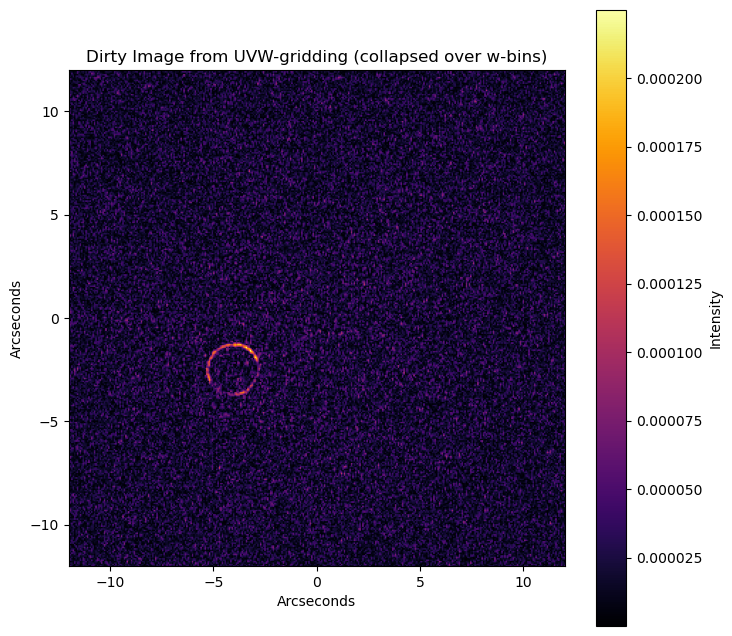

In [17]:
# ----------------------------------------------------------
# Make a dirty image from the collapsed uv grid (like before)
# ----------------------------------------------------------
u_max = np.max(np.abs(uu))  # consistent with your previous fov calc
fov_arcseconds = 206265 * npix / (2.0 * u_max)
arcseconds_per_pixel = fov_arcseconds / npix
x_arcsec = (np.arange(npix) - (npix // 2)) * arcseconds_per_pixel
y_arcsec = (np.arange(npix) - (npix // 2)) * arcseconds_per_pixel

dirty_image_collapse = np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(combined_vis_collapse)))
dirty_image_collapse = np.abs(dirty_image_collapse)

plt.figure(figsize=(8, 8))
plt.imshow(
    dirty_image_collapse,
    extent=[x_arcsec[0], x_arcsec[-1], y_arcsec[0], y_arcsec[-1]],
    origin="lower",
    cmap="inferno",
)
plt.colorbar(label="Intensity")
plt.title("Dirty Image from UVW-gridding (collapsed over w-bins)")
plt.xlabel("Arcseconds")
plt.ylabel("Arcseconds")
plt.xlim(-12, 12)
plt.ylim(-12, 12)
plt.show()

### Step 9 (optional): Compare UVW gridding to just UV gridding

Here we compare VisCube's `grid_cube_all_stats_wbinned` to VisCube's `grid_cube_all_stats`.

100%|█| 1/1 [00:21<00:00, 21.45s/channel, coarse_std_im=1238, coarse_std_re=1238


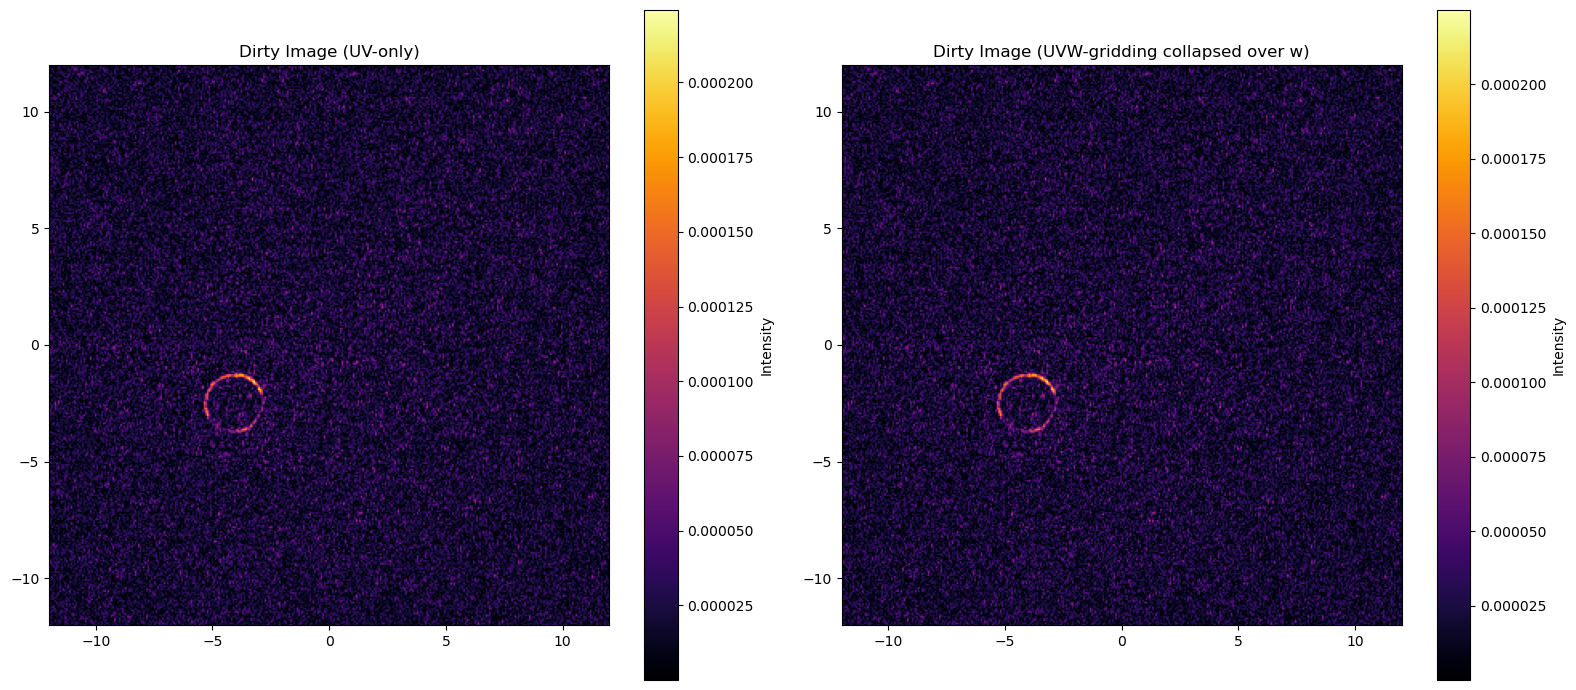

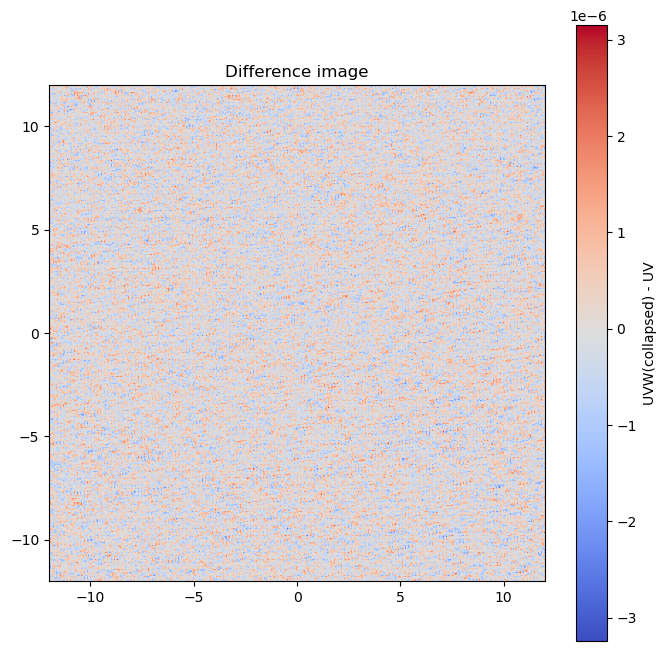

In [18]:
# ----------------------------------------------------------
# Optional sanity check: compare with classic UV-only gridding
# (using viscube's uv-only helper so the window/edges match)
# ----------------------------------------------------------
mean_re_uv, mean_im_uv, _, _, counts_uv, u_edges2, v_edges2 = grid_cube_all_stats(
    frequencies=np.array([0.0]),
    uu=UU,
    vv=VV,
    vis_re=RE,
    vis_imag=IM,
    weight=WG,
    npix=npix,
    pad_uv=pad_uv,
    window_name=window_name,
    window_kwargs=window_kwargs,
    p_metric=1,
    std_workers=6,
    std_min_effective=5,
    std_expand_step=0.1,
)

# flip-back for comparison (same reason as above)
#mean_re_uv = np.flip(mean_re_uv, axis=1)
#mean_im_uv = np.flip(mean_im_uv, axis=1)

combined_vis_uv = mean_re_uv[0] + 1j * mean_im_uv[0]
dirty_image_uv = np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(combined_vis_uv)))
dirty_image_uv = np.abs(dirty_image_uv)

plt.figure(figsize=(16, 7))

plt.subplot(1, 2, 1)
plt.imshow(
    dirty_image_uv,
    extent=[x_arcsec[0], x_arcsec[-1], y_arcsec[0], y_arcsec[-1]],
    origin="lower",
    cmap="inferno",
)
plt.colorbar(label="Intensity")
plt.title("Dirty Image (UV-only)")
plt.xlim(-12, 12)
plt.ylim(-12, 12)

plt.subplot(1, 2, 2)
plt.imshow(
    dirty_image_collapse,
    extent=[x_arcsec[0], x_arcsec[-1], y_arcsec[0], y_arcsec[-1]],
    origin="lower",
    cmap="inferno",
)
plt.colorbar(label="Intensity")
plt.title("Dirty Image (UVW-gridding collapsed over w)")
plt.xlim(-12, 12)
plt.ylim(-12, 12)

plt.tight_layout()
plt.show()

# difference / ratio view (optional)
plt.figure(figsize=(8, 8))
diff = dirty_image_collapse - dirty_image_uv
plt.imshow(
    diff,
    extent=[x_arcsec[0], x_arcsec[-1], y_arcsec[0], y_arcsec[-1]],
    origin="lower",
    cmap="coolwarm",
)
plt.colorbar(label="UVW(collapsed) - UV")
plt.title("Difference image")
plt.xlim(-12, 12)
plt.ylim(-12, 12)
plt.show()